<a href="https://colab.research.google.com/github/Jabaananth/Brain-Tumor-MRI-Image-Classification/blob/main/Brain_Tumor_Classification_mobilenet_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the required Libraries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

# Using the GPU

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Mounting drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_dir = '/content/drive/MyDrive/Tumour-20250818T130228Z-1-001/Tumour/train'
val_dir = '/content/drive/MyDrive/Tumour-20250818T130228Z-1-001/Tumour/valid'
test_dir = "/content/drive/MyDrive/Tumour-20250818T130228Z-1-001/Tumour/test"

# Data Augumentation

In [5]:
# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]

    # Data augmentation parameters
    rotation_range=20,  # Random rotation between -20 and +20 degrees
    width_shift_range=0.2,  # Random horizontal shift by ±20% of width
    height_shift_range=0.2,  # Random vertical shift by ±20% of height
    zoom_range=0.2,  # Random zoom between 80% and 120%
    horizontal_flip=True,  # Random horizontal flipping
    vertical_flip=False,  # No vertical flipping (can enable if appropriate)
    fill_mode='nearest'  # Strategy for filling in newly created pixels
)

# Validation and test generators (only rescaling, no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
# Set image size and batch size
img_width, img_height = 224, 224  # Adjust as needed
batch_size = 32  # Adjust as needed

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'  # or 'binary' if you have two classes
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important for evaluating the test set
)

Found 1694 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 207 images belonging to 4 classes.


# Get the classnames and number of classes

In [7]:
test_generator.class_indices

{'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}

In [8]:
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)
print(f"Class names: {class_names}")
print(f"Number of classes: {num_classes}")

Class names: ['glioma', 'meningioma', 'no_tumor', 'pituitary']
Number of classes: 4


# Building a custom model

In [9]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
epochs = 10
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.5075 - loss: 1.1494 - precision: 0.6874 - recall: 0.2086 

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


52/52 ━━━━━━━━━━━━━━━━━━━━ 1175s 23s/step - accuracy: 0.5080 - loss: 1.1484 - precision: 0.6878 - recall: 0.2095 - val_accuracy: 0.5083 - val_loss: 1.0728 - val_precision: 0.6468 - val_recall: 0.3396
Epoch 2/10
 1/52 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.6562 - loss: 0.9215 - precision: 0.8750 - recall: 0.4375

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


52/52 ━━━━━━━━━━━━━━━━━━━━ 48s 934ms/step - accuracy: 0.6562 - loss: 0.9215 - precision: 0.8750 - recall: 0.4375 - val_accuracy: 0.5479 - val_loss: 1.0271 - val_precision: 0.6438 - val_recall: 0.3917
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 783ms/step - accuracy: 0.6050 - loss: 0.9638 - precision: 0.7014 - recall: 0.4133 - val_accuracy: 0.4708 - val_loss: 1.3361 - val_precision: 0.5096 - val_recall: 0.3875
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6562 - loss: 1.2121 - precision: 0.6250 - recall: 0.4688 - val_accuracy: 0.5021 - val_loss: 1.1324 - val_precision: 0.5766 - val_recall: 0.4000
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 565ms/step - accuracy: 0.6812 - loss: 0.8547 - precision: 0.7478 - recall: 0.5452 - val_accuracy: 0.5917 - val_loss: 1.0627 - val_precision: 0.6207 - val_recall: 0.5250
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.4688 - loss: 1.3565 - precision: 0.4483 - recall: 0.4062 - val_accuracy: 0.6146 - val_loss: 1.0062 - val

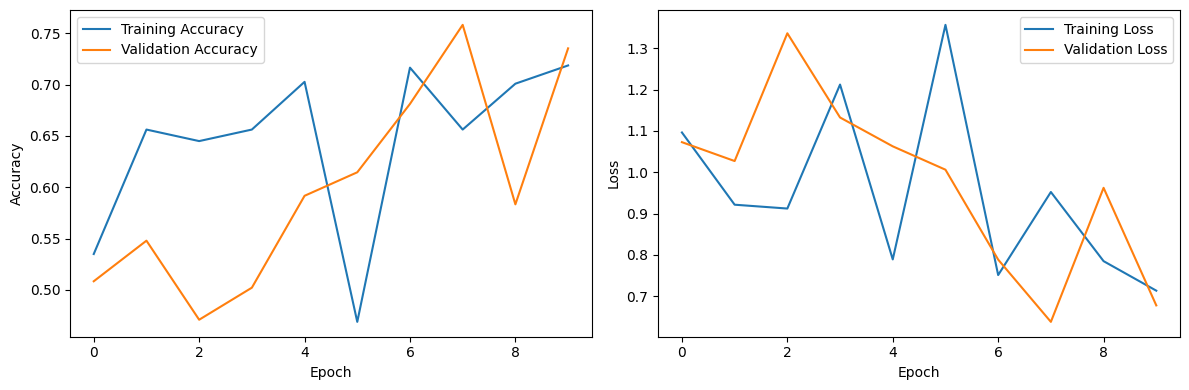

In [15]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

In [16]:
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_generator)
print(f'\nTest accuracy: {test_acc:.4f}')
print(f'Test precision: {test_precision:.4f}')
print(f'Test recall: {test_recall:.4f}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 114s 19s/step - accuracy: 0.7424 - loss: 0.6802 - precision: 0.7871 - recall: 0.6648

Test accuracy: 0.7440
Test precision: 0.7861
Test recall: 0.6570


In [17]:
test_generator.reset()
predictions = model.predict(test_generator, steps=test_generator.samples // batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step


In [18]:
true_classes = test_generator.classes

In [19]:
print('\nClassification Report:')
print(classification_report(true_classes, predicted_classes, target_names=class_names))

# Confusion matrix
conf_mat = confusion_matrix(true_classes, predicted_classes)
print('\nConfusion Matrix:')
print(conf_mat)


Classification Report:
              precision    recall  f1-score   support

      glioma       0.77      0.86      0.82        74
  meningioma       0.72      0.26      0.38        50
    no_tumor       0.64      0.88      0.74        33
   pituitary       0.79      0.96      0.86        50

    accuracy                           0.74       207
   macro avg       0.73      0.74      0.70       207
weighted avg       0.74      0.74      0.71       207


Confusion Matrix:
[[64  5  4  1]
 [18 13 11  8]
 [ 0  0 29  4]
 [ 1  0  1 48]]


# Using Transfer Learning models

In [63]:
from tensorflow.keras.applications import (VGG16, ResNet50, MobileNet,
                                          InceptionV3, EfficientNetB0)
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

model_comparison1 = []

# VGG16, MobileNet,RESNET50, InceptionV3,EfficientNet

# VGG16

In [64]:
def evaluate_vgg16():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy',
                         tf.keras.metrics.Precision(name='precision'),
                         tf.keras.metrics.Recall(name='recall')])

    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=10,
        callbacks=[EarlyStopping(patience=3)]
    )

    return model, history

vgg_model, vgg_history = evaluate_vgg16()
model_comparison1.append({
    'Model': 'VGG16',
    'Val Accuracy': max(vgg_history.history['val_accuracy']),
    'Val Precision': max(vgg_history.history['val_precision']),
    'Val Recall': max(vgg_history.history['val_recall']),
    'Parameters': f"{vgg_model.count_params():,}",
    'Inference Time': 'Medium',
    'Best For': 'Medium-sized datasets'
})

Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 42s 724ms/step - accuracy: 0.3382 - loss: 1.4034 - precision: 0.3950 - recall: 0.0201 - val_accuracy: 0.4960 - val_loss: 1.2168 - val_precision: 0.9259 - val_recall: 0.0498
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 623ms/step - accuracy: 0.4825 - loss: 1.1847 - precision: 0.8092 - recall: 0.1432 - val_accuracy: 0.5837 - val_loss: 1.1120 - val_precision: 0.8261 - val_recall: 0.1892
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 648ms/step - accuracy: 0.5734 - loss: 1.0906 - precision: 0.8419 - recall: 0.2027 - val_accuracy: 0.5797 - val_loss: 1.0601 - val_precision: 0.7640 - val_recall: 0.2450
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 629ms/step - accuracy: 0.5922 - loss: 1.0336 - precision: 0.7826 - recall: 0.2829 - val_accuracy: 0.6614 - val_loss: 0.9694 - val_precision: 0.7989 - val_recall: 0.3008
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 642ms/step - accuracy: 0.6335 - loss: 0.9719 - precision: 0.8128 - recall: 0.2949 - val_accuracy: 0.6793 - val_los

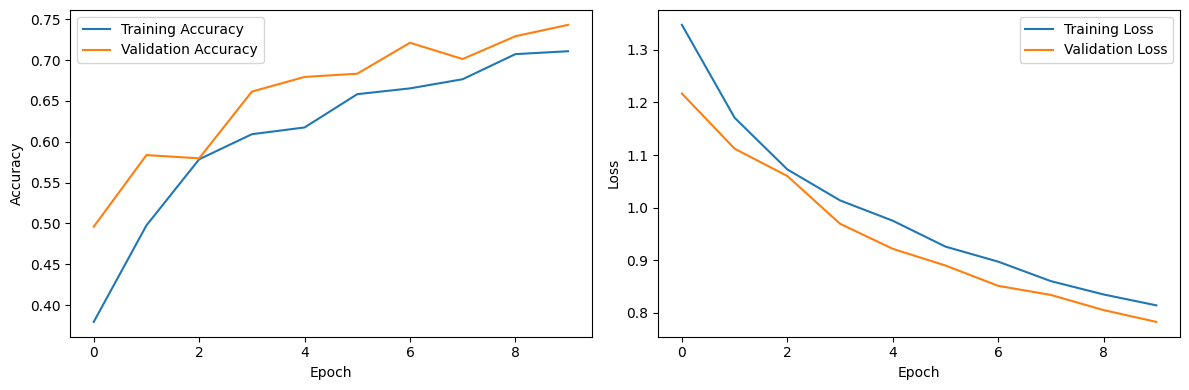

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 277ms/step - accuracy: 0.7905 - loss: 0.6801 - precision: 0.9195 - recall: 0.5769

Test accuracy: 0.7778
Test precision: 0.9180
Test recall: 0.5411
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 279ms/step


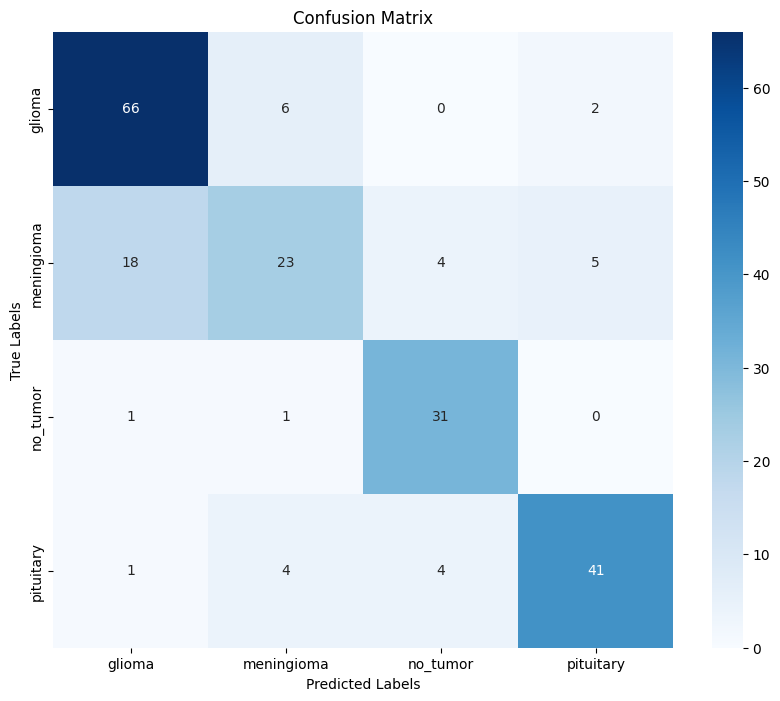

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(vgg_history)


# Evaluate on test set (assuming you have a test_generator)
test_generator.reset() # Reset the generator before evaluating
test_loss, test_acc, test_precision, test_recall = vgg_model.evaluate(test_generator)
print(f'\nTest accuracy: {test_acc:.4f}')
print(f'Test precision: {test_precision:.4f}')
print(f'Test recall: {test_recall:.4f}')


# Generate predictions
predictions = vgg_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes
true_classes = test_generator.classes

# Confusion Matrix
conf_mat = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# MobileNet

In [66]:
def evaluate_mobilenet():
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy', 'precision', 'recall'])

    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=10,
        callbacks=[EarlyStopping(patience=3)]
    )

    return model, history

mobilenet_model, mobilenet_history = evaluate_mobilenet()
model_comparison1.append({
    'Model': 'MobileNet',
    'Val Accuracy': max(mobilenet_history.history['val_accuracy']),
    'Val Precision': max(mobilenet_history.history['val_precision']),
    'Val Recall': max(mobilenet_history.history['val_recall']),
    'Parameters': f"{mobilenet_model.count_params():,}",
    'Inference Time': 'Fast',
    'Best For': 'Mobile/Edge devices'
})

Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 47s 740ms/step - accuracy: 0.4659 - loss: 1.3231 - precision: 0.5156 - recall: 0.3357 - val_accuracy: 0.7669 - val_loss: 0.5813 - val_precision: 0.8277 - val_recall: 0.6793
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 574ms/step - accuracy: 0.7833 - loss: 0.5922 - precision: 0.8389 - recall: 0.6965 - val_accuracy: 0.8287 - val_loss: 0.4648 - val_precision: 0.8578 - val_recall: 0.7689
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 617ms/step - accuracy: 0.8234 - loss: 0.4873 - precision: 0.8553 - recall: 0.7722 - val_accuracy: 0.8347 - val_loss: 0.4241 - val_precision: 0.8808 - val_recall: 0.7948
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 632ms/step - accuracy: 0.8477 - loss: 0.4319 - precision: 0.8733 - recall: 0.8077 - val_accuracy: 0.8745 - val_loss: 0.3537 - val_precision: 0.8954 - val_recall: 0.8526
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 567ms/step - accuracy: 0.8834 - loss: 0.3542 - precision: 0.9067 - recall: 0.8436 - val_accuracy: 0.8645 - val_los

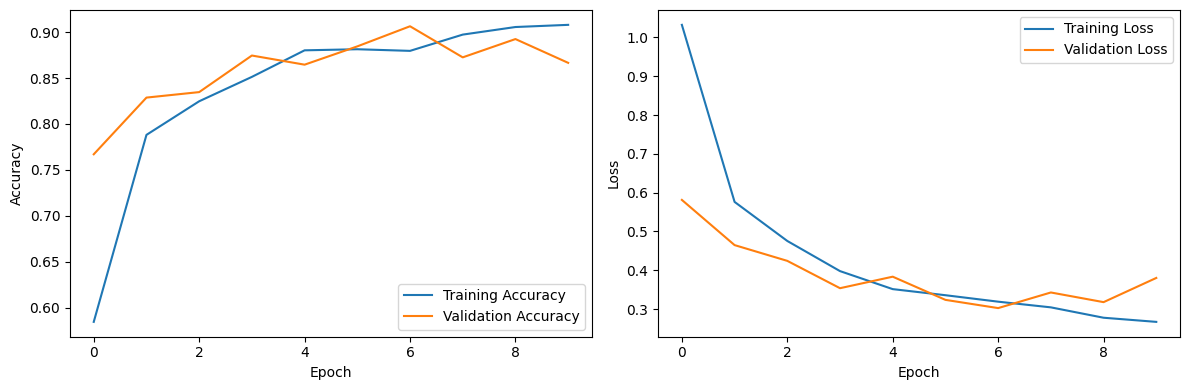

In [67]:
plot_history(mobilenet_history)

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 486ms/step - accuracy: 0.9042 - loss: 0.2324 - precision: 0.9162 - recall: 0.8969

MobileNet Test accuracy: 0.8937
MobileNet Test precision: 0.9104
MobileNet Test recall: 0.8841
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 713ms/step


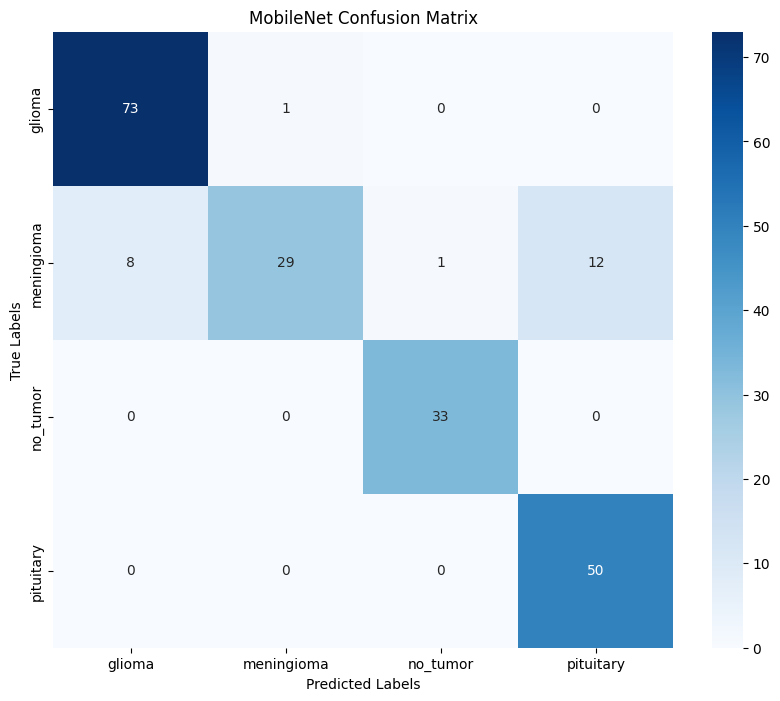

In [68]:
test_generator.reset()  # Reset the generator before evaluating
test_loss, test_acc, test_precision, test_recall = mobilenet_model.evaluate(test_generator)
print(f'\nMobileNet Test accuracy: {test_acc:.4f}')
print(f'MobileNet Test precision: {test_precision:.4f}')
print(f'MobileNet Test recall: {test_recall:.4f}')

# Generate predictions for MobileNet
predictions = mobilenet_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes for MobileNet
true_classes = test_generator.classes

# Confusion Matrix for MobileNet
conf_mat = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix for MobileNet using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('MobileNet Confusion Matrix')
plt.show()

# Models comparison

In [74]:
import pandas as pd
comparison_df = pd.DataFrame(model_comparison1)
comparison_df = comparison_df.sort_values('Val Accuracy', ascending=False)
comparison_df.style.background_gradient(cmap='Blues', subset=['Val Accuracy', 'Val Precision', 'Val Recall'])

,Model,Val Accuracy,Val Precision,Val Recall,Parameters,Inference Time,Best For
1,MobileNet,0.906375,0.921325,0.886454,"3,232,964",Fast,Mobile/Edge devices
0,VGG16,0.743028,0.925926,0.462151,"14,716,740",Medium,Medium-sized datasets


In [75]:
comparison_df.to_csv('/content/drive/MyDrive/model_comparison1.csv', index=False)

In [76]:
import pandas as pd
df=pd.read_csv('/content/drive/MyDrive/model_comparison1.csv')
df

,Model,Val Accuracy,Val Precision,Val Recall,Parameters,Inference Time,Best For
0,MobileNet,0.906375,0.921325,0.886454,"3,232,964",Fast,Mobile/Edge devices
1,VGG16,0.743028,0.925926,0.462151,"14,716,740",Medium,Medium-sized datasets


The best performing model is:
Model                       MobileNet
Val Accuracy                 0.906375
Val Precision                0.921325
Val Recall                   0.886454
Parameters                  3,232,964
Inference Time                   Fast
Best For          Mobile/Edge devices
Name: 0, dtype: object


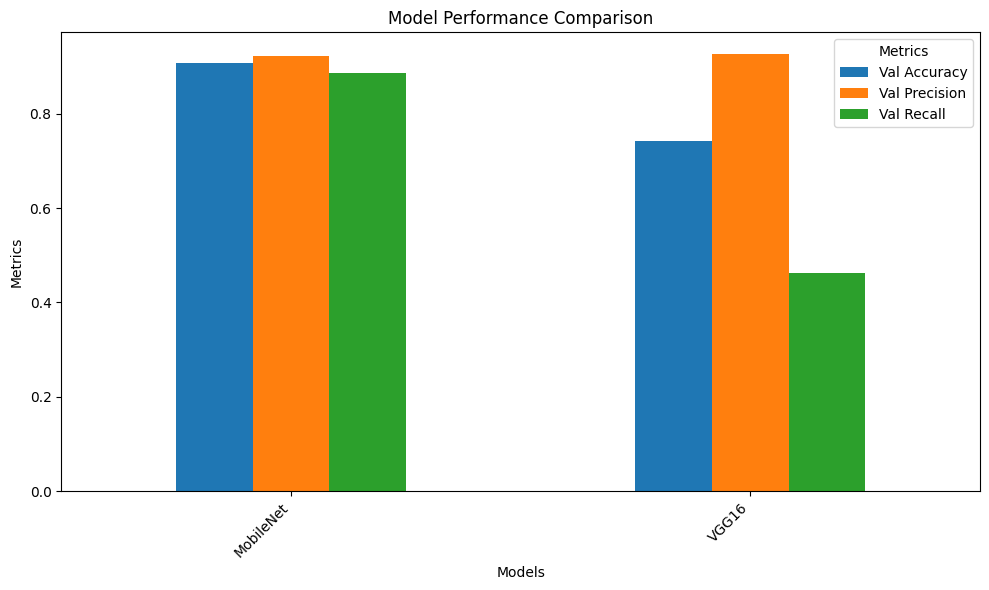

In [77]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/content/drive/MyDrive/model_comparison1.csv')


# Find the best model based on validation accuracy
best_model = df.loc[df['Val Accuracy'].idxmax()]

print(f"The best performing model is:\n{best_model}")

# Plotting the bar chart
plt.figure(figsize=(10, 6))
df.plot(x='Model', y=['Val Accuracy', 'Val Precision', 'Val Recall'], kind='bar', ax=plt.gca())
plt.title('Model Performance Comparison')
plt.ylabel('Metrics')
plt.xlabel('Models')


plt.xticks(rotation=45, ha='right')
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()

# Save the model

In [78]:
mobilenet_model.save('/content/drive/MyDrive/model.h5')

# Streamlit App

In [79]:
!pip install streamlit numpy pillow tensorflow

In [80]:
# @title Setup code
!pip install -q streamlit
!wget https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
!chmod +x cloudflared-linux-amd64
import subprocess
subprocess.Popen(["./cloudflared-linux-amd64", "tunnel", "--url", "http://localhost:8501"])
!nohup /content/cloudflared-linux-amd64 tunnel --url http://localhost:8501 &

--2025-09-03 09:31:01--  https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/cloudflare/cloudflared/releases/download/2025.8.1/cloudflared-linux-amd64 [following]
--2025-09-03 09:31:01--  https://github.com/cloudflare/cloudflared/releases/download/2025.8.1/cloudflared-linux-amd64
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/106867604/0593a2fc-d1d2-46e1-aaac-c8f6bd891eca?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-09-03T10%3A20%3A49Z&rscd=attachment%3B+filename%3Dcloudflared-linux-amd64&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-09-

In [91]:
%%writefile app.py

import streamlit as st
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import os


classes = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

# Load the trained model
@st.cache_resource
def load_custom_model():
    model_path = '/content/drive/MyDrive/model.h5'
    if not os.path.exists(model_path):
        st.error(f"Model file not found at {model_path}")
        return None
    return load_model(model_path)

model = load_custom_model()

# Streamlit app
st.set_page_config(page_title="Brain Tumor Classifier", layout="centered")
st.title("🧠 Brain Tumor Classification")
st.write(f"Upload a Tumour to classify")

# File uploader
uploaded_file = st.file_uploader("Upload an MRI image...",
                                type=["jpg", "jpeg", "png"])

if uploaded_file is not None and model is not None:
    # Display the uploaded image
    image = Image.open(uploaded_file)
    st.image(image, caption='MRI_Image', use_container_width=True)

    # Preprocess the image
    image = image.resize((224, 224))  # Match your model's expected input
    image_array = img_to_array(image)
    image_array = image_array / 255.0  # Normalize (if your model expects this)
    image_array = np.expand_dims(image_array, axis=0)

    # Make prediction
    with st.spinner('Identifying Tumour...'):
        predictions = model.predict(image_array)
        predicted_class = classes[np.argmax(predictions)]
        confidence = np.max(predictions)


    # Display results
    st.subheader("Predicted Results:")
    st.success(f"Tumour: {predicted_class}")
    st.info(f"Confidence: {confidence*100:.2f}%")

Overwriting app.py


In [82]:
!streamlit run /content/app.py &>/content/logs.txt &

In [83]:
!grep -o 'https://.*\.trycloudflare.com' nohup.out | head -n 1 | xargs -I {} echo "Your tunnel url {}"

Your tunnel url https://favorites-actress-graphics-identifier.trycloudflare.com
